In [1]:
!pip install --upgrade numpy
import os
import cv2
import numpy as np
import nibabel as nib
from scipy import ndimage
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Defaulting to user installation because normal site-packages is not writeable


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-19 10:14:37.913225: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 10:14:38.370258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 10:14:39.755718: W tenso

In [2]:
image_folder_path = "images"
data_file_path = "PTs_500_4k_blinded.xlsx"  

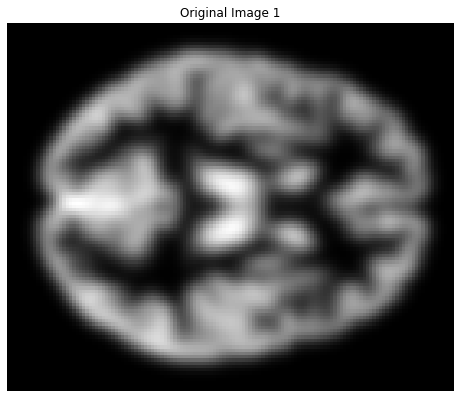

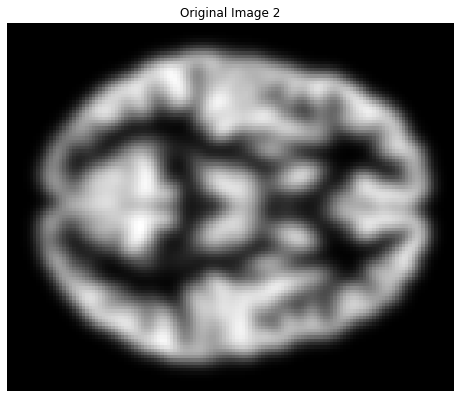

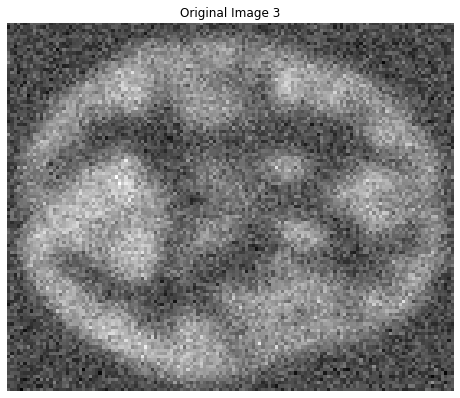

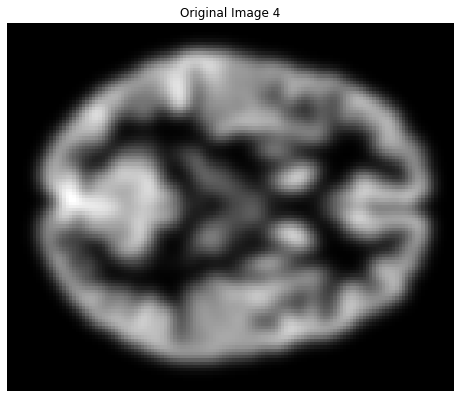

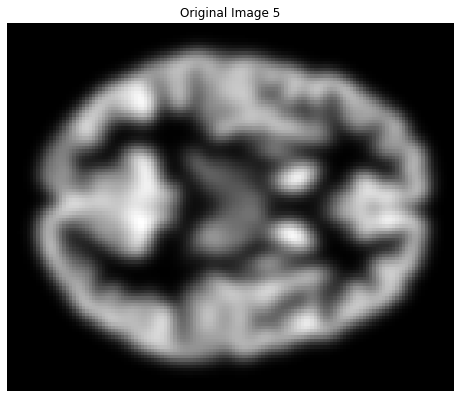

In [3]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

image_folder_path = "images"

image_filenames = [filename for filename in os.listdir(image_folder_path) if filename.endswith(".nii")]

num_images_to_display = min(5, len(image_filenames))
for i in range(num_images_to_display):
    image = nib.load(os.path.join(image_folder_path, image_filenames[i])).get_fdata()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, image.shape[2] // 2], cmap='gray')  
    plt.title(f"Original Image {i+1}")
    plt.axis('off')
    plt.show()


In [4]:
scale_factor = 0.5

In [5]:
data = pd.read_excel(data_file_path)
thresholds1 = data["PT500"] 
thresholds2 = data["PT4000"]

In [6]:
#No need to run the below code as it has already creted the augumented data set.

In [7]:
"""
import os
import nibabel as nib
import torchio as tio
import matplotlib.pyplot as plt

image_folder_path = "images"

transform = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=(0.1, 0.1), isotropic=True),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=7),
    tio.RandomNoise(std=0.1),
    tio.RandomFlip(axes=(0, 1)),
])

for filename in os.listdir(image_folder_path):
    if filename.endswith(".nii"): 
        image_path = os.path.join(image_folder_path, filename)
        image = nib.load(image_path).get_fdata()
        tio_image = tio.ScalarImage(image_path)
        augmented_image = transform(tio_image)
        if augmented_image.data.shape == tio_image.data.shape:
            augmented_image.save(image_path.replace(".nii", "_augmented.nii"))
        else:
            print(f"Image shape mismatch for '{filename}'. Augmented shape: {augmented_image.data.shape}, Original shape: {tio_image.data.shape}")
"""

'\nimport os\nimport nibabel as nib\nimport torchio as tio\nimport matplotlib.pyplot as plt\n\nimage_folder_path = "images"\n\ntransform = tio.Compose([\n    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=(0.1, 0.1), isotropic=True),\n    tio.RandomElasticDeformation(num_control_points=5, max_displacement=7),\n    tio.RandomNoise(std=0.1),\n    tio.RandomFlip(axes=(0, 1)),\n])\n\nfor filename in os.listdir(image_folder_path):\n    if filename.endswith(".nii"): \n        image_path = os.path.join(image_folder_path, filename)\n        image = nib.load(image_path).get_fdata()\n        tio_image = tio.ScalarImage(image_path)\n        augmented_image = transform(tio_image)\n        if augmented_image.data.shape == tio_image.data.shape:\n            augmented_image.save(image_path.replace(".nii", "_augmented.nii"))\n        else:\n            print(f"Image shape mismatch for \'{filename}\'. Augmented shape: {augmented_image.data.shape}, Original shape: {tio_image.data.shape}")\n

In [8]:
print(thresholds1.head(5))

0    25.0
1     5.0
2     5.0
3     5.0
4     2.5
Name: PT500, dtype: float64


In [9]:
print(thresholds2.head(5))

0    72.5
1    10.0
2    45.0
3    15.0
4    62.5
Name: PT4000, dtype: float64


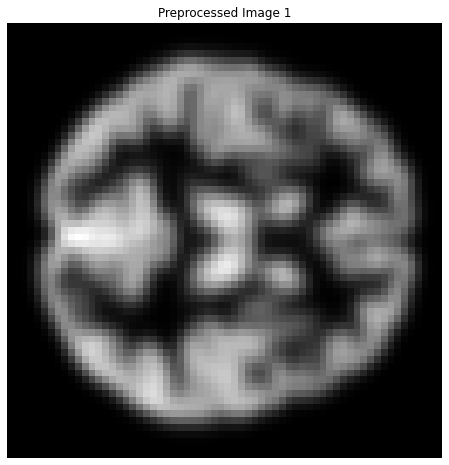

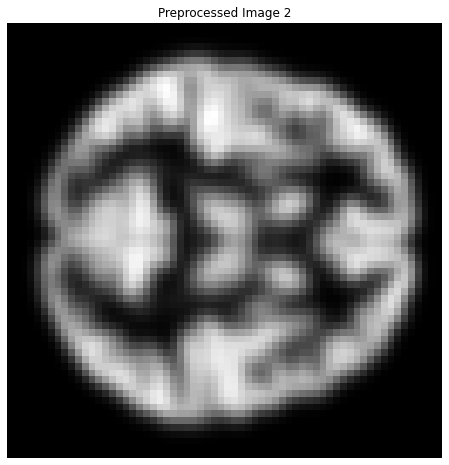

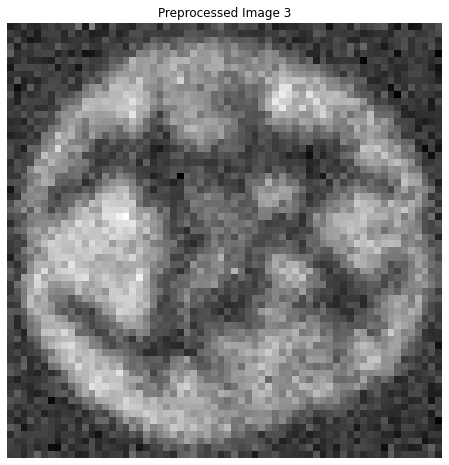

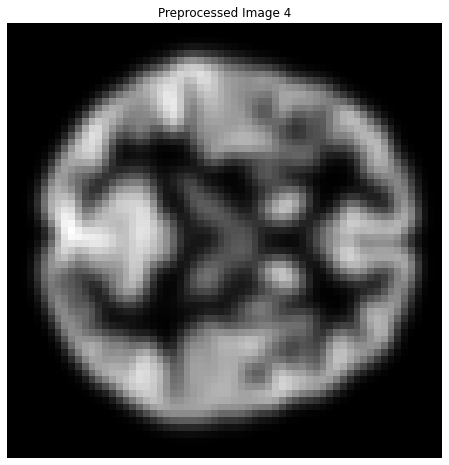

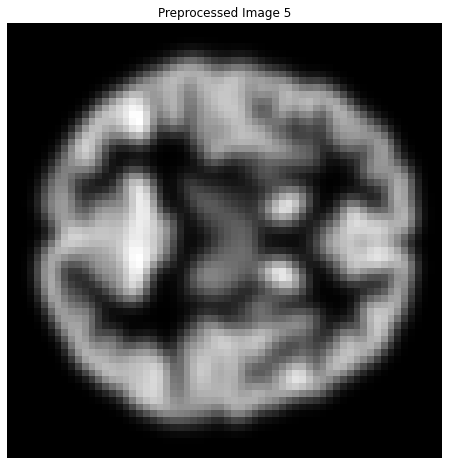

In [10]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

image_folder_path = "images"

image_size = (64, 64, 64)

processed_images = []

def preprocess_image(image_path):
    image = nib.load(image_path).get_fdata()
    scale_factor = tuple(new_dim / old_dim for new_dim, old_dim in zip(image_size, image.shape))
    resized_image = ndimage.zoom(image, scale_factor, order=1) 
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image

for filename in os.listdir(image_folder_path):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        image_path = os.path.join(image_folder_path, filename)
        processed_image = preprocess_image(image_path)
        processed_images.append(processed_image)

num_images_to_display = min(5, len(processed_images))
for i in range(num_images_to_display):
    image = processed_images[i]
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, image.shape[2] // 2], cmap='gray')
    plt.title(f"Preprocessed Image {i + 1}")
    plt.axis('off')
    plt.show()


In [11]:
print(f"processed_images shape: {len(processed_images)}")

processed_images shape: 342


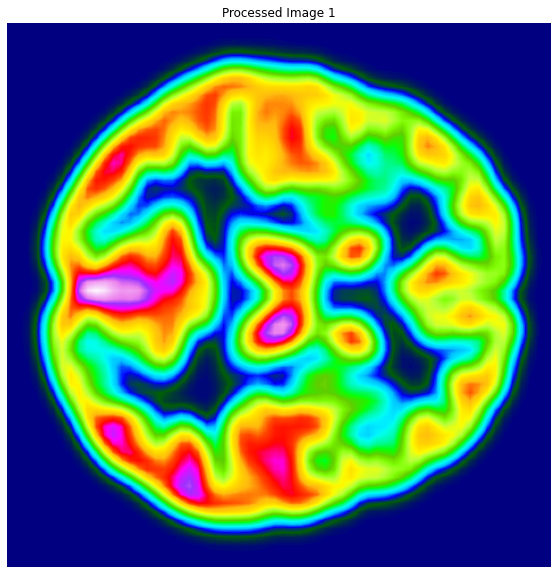

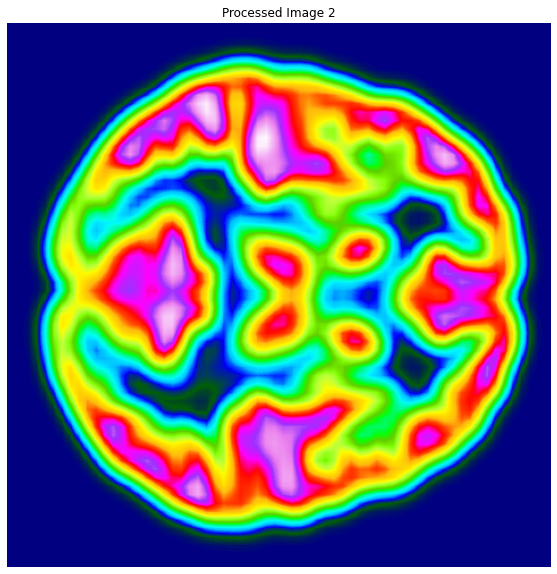

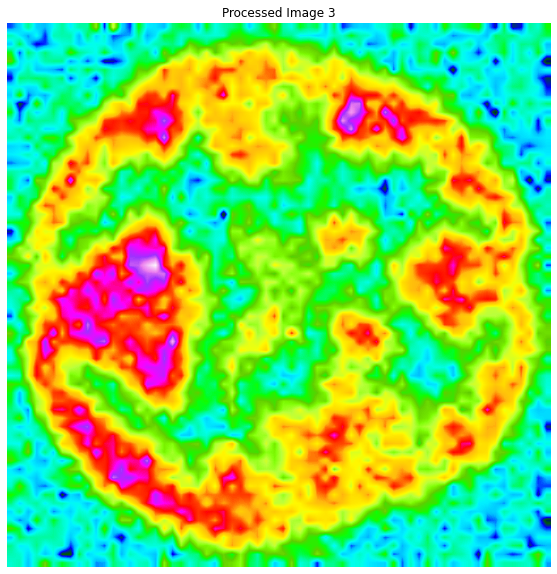

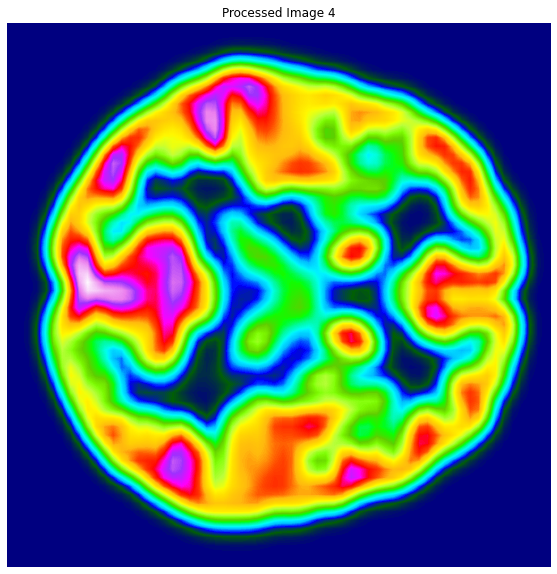

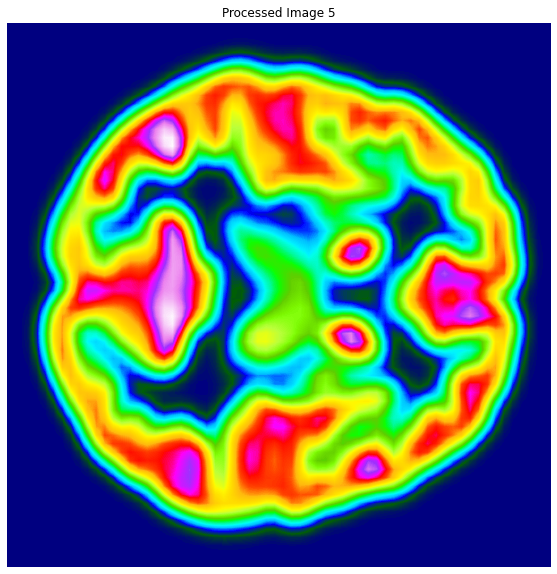

In [12]:
import matplotlib.pyplot as plt

num_images_to_display = 5
for i in range(num_images_to_display):
    plt.figure(figsize=(10, 10))
    plt.imshow(processed_images[i][:, :, 32], cmap='gist_ncar', interpolation='bilinear')
    plt.title(f"Processed Image {i+1}")
    plt.axis('off')
    plt.show()



In [13]:
processed_images = np.array(processed_images)
thresholds1 = thresholds1.to_numpy()
thresholds2 = thresholds2.to_numpy()

In [14]:
print(f"processed_images shape: {len(processed_images)}")

processed_images shape: 342


In [15]:
print(f"threshold1 shape: {len(thresholds1)}")
print(f"threshold2 shape: {len(thresholds2)}")

threshold1 shape: 171
threshold2 shape: 171


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

num_original_samples = len(thresholds1)
num_new_samples = len(processed_images) - num_original_samples

if num_new_samples > 0:
    interp_func1 = interp1d(np.arange(len(thresholds1)), thresholds1, kind='linear')
    new_thresholds1 = interp_func1(np.linspace(0, len(thresholds1) - 1, num_new_samples))
    interp_func2 = interp1d(np.arange(len(thresholds2)), thresholds2, kind='linear')
    new_thresholds2 = interp_func2(np.linspace(0, len(thresholds2) - 1, num_new_samples))
    thresholds1 = np.concatenate([thresholds1, new_thresholds1])
    thresholds2 = np.concatenate([thresholds2, new_thresholds2])

# 80% train, 20% test
X_train1, X_test1, y_train1, y_test1 = train_test_split(processed_images, thresholds1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(processed_images, thresholds2, test_size=0.2, random_state=42)


In [17]:
print(len(thresholds1))

342


In [18]:
print(f"Xtest shape: {len(X_test1)}")

Xtest shape: 69


In [19]:
print(f"ytrain shape: {len(y_train1)}")

ytrain shape: 273


In [20]:
print("X_train2 shape:", X_train2.shape)
print("X_test2 shape:", X_test2.shape)

X_train2 shape: (273, 64, 64, 64)
X_test2 shape: (69, 64, 64, 64)


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2.reshape(-1, X_train2.shape[-1])).reshape(X_train2.shape)
X_test2 = scaler.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)


input_shape = (64, 64, 64, 1)
X_train1 = X_train1.reshape((273, 64, 64, 64, 1))
X_test1 = X_test1.reshape((69, 64, 64, 64, 1))

inputs = Input(shape=input_shape)
x = Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.7)(x)  #0.7
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_absolute_error' , metrics=['mse', 'mae'])

print("X_train1 shape:", X_train1.shape)
if X_train1.shape[1:] != input_shape:
    X_train1 = X_train1.reshape((X_train1.shape[0], 64, 64, 64, 1))
    X_test1 = X_test1.reshape((X_test1.shape[0], 64, 64, 64, 1))
    print("Reshaped X_train1 to:", X_train1.shape)

print("X_train2 shape:", X_train2.shape)
if X_train2.shape[1:] != input_shape:
    X_train2 = X_train2.reshape((X_train2.shape[0], 64, 64, 64, 1))
    X_test2 = X_test2.reshape((X_test2.shape[0], 64, 64, 64, 1))
    print("Reshaped X_train2 to:", X_train2.shape)

def scheduler1(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.02)

def scheduler2(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.02)

lr_scheduler1 = LearningRateScheduler(scheduler1)
lr_scheduler2 = LearningRateScheduler(scheduler2)

epochs1 = 14
epochs2 = 15

print("Training CNN for threshold 1...")
history1 = model.fit(X_train1, y_train1, epochs=epochs1, verbose=1, callbacks=[lr_scheduler1], validation_data=(X_test1, y_test1))
print("CNN Evaluation for threshold 1:")
loss1 = model.evaluate(X_test1, y_test1, verbose=0)
print("Loss for threshold 1:", loss1)
y_pred1 = model.predict(X_test1)

mse_cnn1 = mean_squared_error(y_test1, y_pred1)
mae_cnn1 = mean_absolute_error(y_test1, y_pred1)
r2_cnn1 = r2_score(y_test1, y_pred1)

print("Mean Squared Error (MSE) for threshold 1:", mse_cnn1)
print("Mean Absolute Error (MAE) for threshold 1:", mae_cnn1)
print("R-squared (R2) Score for threshold 1:", r2_cnn1)


print("Training CNN for threshold 2...")
history2 = model.fit(X_train2, y_train2, epochs=epochs2, verbose=1, callbacks=[lr_scheduler2], validation_data=(X_test2, y_test2))
print("CNN Evaluation for threshold 2:")
loss2 = model.evaluate(X_test2, y_test2, verbose=0)
print("Loss for threshold 2:", loss2)
y_pred2 = model.predict(X_test2)
mse_cnn2 = mean_squared_error(y_test2, y_pred2)
mae_cnn2 = mean_absolute_error(y_test2, y_pred2)
r2_cnn2 = r2_score(y_test2, y_pred2)

print("Mean Squared Error (MSE) for threshold 2:", mse_cnn2)
print("Mean Absolute Error (MAE) for threshold 2:", mae_cnn2)
print("R-squared (R2) Score for threshold 2:", r2_cnn2)

2024-04-19 10:14:57.447184: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


X_train1 shape: (273, 64, 64, 64, 1)
X_train2 shape: (273, 64, 64, 64)
Reshaped X_train2 to: (273, 64, 64, 64, 1)
Training CNN for threshold 1...
Epoch 1/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 15.3207 - mae: 11.8358 - mse: 231.2912 - val_loss: 15.0392 - val_mae: 10.9003 - val_mse: 195.0328 - learning_rate: 1.0000e-04
Epoch 2/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 14.4320 - mae: 11.0747 - mse: 205.8982 - val_loss: 14.8854 - val_mae: 10.8945 - val_mse: 194.8570 - learning_rate: 1.0000e-04
Epoch 3/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 15.3897 - mae: 12.1491 - mse: 237.4418 - val_loss: 14.7380 - val_mae: 10.8882 - val_mse: 194.6672 - learning_rate: 1.0000e-04
Epoch 4/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 15.2771 - mae: 12.1813 - mse: 247.2083 - val_loss: 14.5966 - val_mae: 10.8811 - val_mse: 194.4513 - learning_rate: 1.0000e-04
Epoch 5/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 15.1223 - mae: 12.1819 - mse: 240.8372 - val_loss: 14.4606 -

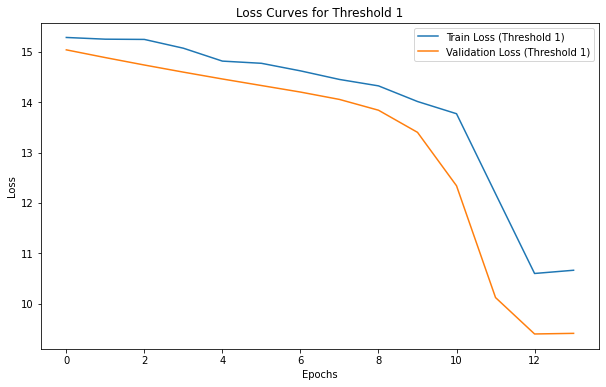

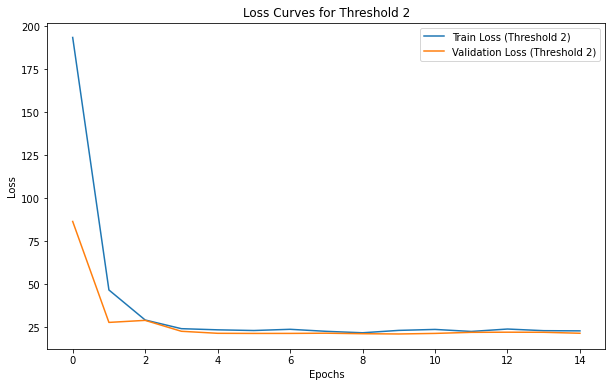

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Train Loss (Threshold 1)')
plt.plot(history1.history['val_loss'], label='Validation Loss (Threshold 1)')
plt.title('Loss Curves for Threshold 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Train Loss (Threshold 2)')
plt.plot(history2.history['val_loss'], label='Validation Loss (Threshold 2)')
plt.title('Loss Curves for Threshold 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
flattened_images = processed_images.reshape((processed_images.shape[0], -1))

X_train1, X_test1, y_train1, y_test1 = train_test_split(flattened_images, thresholds1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(flattened_images, thresholds2, test_size=0.2, random_state=42)

In [24]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_regression, k=160)  
selected_features = selector.fit_transform(flattened_images, thresholds1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

svm_model1 = SVR(kernel='rbf', C=100, gamma='auto')
svm_model2 = SVR(kernel='rbf', C=60, gamma='auto')

print("Training SVM for threshold 1...")
svm_model1.fit(X_train1, y_train1)

print("Training SVM for threshold 2...")
svm_model2.fit(X_train2, y_train2)

print("SVM Evaluation for threshold 1:")
y_pred_svm1 = svm_model1.predict(X_test1)
mse_svm1 = mean_squared_error(y_test1, y_pred_svm1)
mae_svm1 = mean_absolute_error(y_test1, y_pred_svm1)
r2_svm1 = r2_score(y_test1, y_pred_svm1)

print("Mean Squared Error (MSE) for threshold 1:", mse_svm1)
print("Mean Absolute Error (MAE) for threshold 1:", mae_svm1)
print("R-squared (R2) Score for threshold 1:", r2_svm1)

print("SVM Evaluation for threshold 2:")
y_pred_svm2 = svm_model2.predict(X_test2)
mse_svm2 = mean_squared_error(y_test2, y_pred_svm2)
mae_svm2 = mean_absolute_error(y_test2, y_pred_svm2)
r2_svm2 = r2_score(y_test2, y_pred_svm2)

print("Mean Squared Error (MSE) for threshold 2:", mse_svm2)
print("Mean Absolute Error (MAE) for threshold 2:", mae_svm2)
print("R-squared (R2) Score for threshold 2:", r2_svm2)


Training SVM for threshold 1...
Training SVM for threshold 2...
SVM Evaluation for threshold 1:
Mean Squared Error (MSE) for threshold 1: 79.84013553302705
Mean Absolute Error (MAE) for threshold 1: 7.011602921664722
R-squared (R2) Score for threshold 1: -0.005505764038598704
SVM Evaluation for threshold 2:
Mean Squared Error (MSE) for threshold 2: 525.4698399221141
Mean Absolute Error (MAE) for threshold 2: 19.092743928077905
R-squared (R2) Score for threshold 2: -0.027639186218459955


In [33]:
extracted_image_features_train = np.random.rand(X_train1.shape[0], 64) 
extracted_image_features_test = np.random.rand(X_test1.shape[0], 64) 

combined_features_train = np.concatenate((X_train1, extracted_image_features_train), axis=1)
combined_features_test = np.concatenate((X_test1, extracted_image_features_test), axis=1)

hybrid_model1 = RandomForestRegressor(n_estimators=60) #Run with 100, then 80 and 60 
hybrid_model1.fit(combined_features_train, y_train1)

y_pred_1 = hybrid_model1.predict(combined_features_test)
mse1 = mean_squared_error(y_test1, y_pred_1)
mae1 = mean_absolute_error(y_test1, y_pred_1)
r2_1 = r2_score(y_test1, y_pred_1)

print("Mean Squared Error (MSE) for threshold 1:", mse1)
print("Mean Absolute Error (MAE) for threshold 1:", mae1)
print("R-squared (R2) Score for threshold 1:", r2_1)

Mean Squared Error (MSE) for threshold 1: 82.8766857890499
Mean Absolute Error (MAE) for threshold 1: 7.4353864734299515
R-squared (R2) Score for threshold 1: -0.04374804362441975


In [35]:
extracted_image_features_train2 = np.random.rand(X_train2.shape[0], 64) 
extracted_image_features_test2 = np.random.rand(X_test2.shape[0], 64) 

combined_features_train2 = np.concatenate((X_train2, extracted_image_features_train2), axis=1)
combined_features_test2 = np.concatenate((X_test2, extracted_image_features_test2), axis=1)

hybrid_model2 = RandomForestRegressor(n_estimators=60) #Run with 100, then 80 and 60 
hybrid_model2.fit(combined_features_train2, y_train2)

y_pred_2 = hybrid_model2.predict(combined_features_test2)
mse2 = mean_squared_error(y_test2, y_pred_2)
mae2 = mean_absolute_error(y_test2, y_pred_2)
r2_2 = r2_score(y_test2, y_pred_2)

print("Mean Squared Error (MSE) for threshold 2:", mse2)
print("Mean Absolute Error (MAE) for threshold 2:", mae2)
print("R-squared (R2) Score for threshold 2:", r2_2)

Mean Squared Error (MSE) for threshold 2: 536.1610054347826
Mean Absolute Error (MAE) for threshold 2: 19.516304347826082
R-squared (R2) Score for threshold 2: -0.0485474473449099


In [36]:
print("Mean Squared Error (MSE) for threshold 1:", mse_cnn1)
print("Mean Absolute Error (MAE) for threshold 1:", mae_cnn1)
print("R-squared (R2) Score for threshold 1:", r2_cnn1)

print("Mean Squared Error (MSE) for threshold 2:", mse_cnn2)
print("Mean Absolute Error (MAE) for threshold 2:", mae_cnn2)
print("R-squared (R2) Score for threshold 2:", r2_cnn2)

print("Mean Squared Error (MSE) for threshold 1:", mse_svm1)
print("Mean Absolute Error (MAE) for threshold 1:", mae_svm1)
print("R-squared (R2) Score for threshold 1:", r2_svm1)

print("Mean Squared Error (MSE) for threshold 2:", mse_svm2)
print("Mean Absolute Error (MAE) for threshold 2:", mae_svm2)
print("R-squared (R2) Score for threshold 2:", r2_svm2)

print("Mean Squared Error (MSE) for threshold 1:", mse1)
print("Mean Absolute Error (MAE) for threshold 1:", mae1)
print("R-squared (R2) Score for threshold 1:", r2_1)

print("Mean Squared Error (MSE) for threshold 2:", mse2)
print("Mean Absolute Error (MAE) for threshold 2:", mae2)
print("R-squared (R2) Score for threshold 2:", r2_2)

Mean Squared Error (MSE) for threshold 1: 80.16684096258516
Mean Absolute Error (MAE) for threshold 1: 7.303486851678378
R-squared (R2) Score for threshold 1: -0.00962028852393737
Mean Squared Error (MSE) for threshold 2: 553.3580196109804
Mean Absolute Error (MAE) for threshold 2: 18.79073911473371
R-squared (R2) Score for threshold 2: -0.08217892209526778
Mean Squared Error (MSE) for threshold 1: 79.84013553302705
Mean Absolute Error (MAE) for threshold 1: 7.011602921664722
R-squared (R2) Score for threshold 1: -0.005505764038598704
Mean Squared Error (MSE) for threshold 2: 525.4698399221141
Mean Absolute Error (MAE) for threshold 2: 19.092743928077905
R-squared (R2) Score for threshold 2: -0.027639186218459955
Mean Squared Error (MSE) for threshold 1: 82.8766857890499
Mean Absolute Error (MAE) for threshold 1: 7.4353864734299515
R-squared (R2) Score for threshold 1: -0.04374804362441975
Mean Squared Error (MSE) for threshold 2: 536.1610054347826
Mean Absolute Error (MAE) for thresho

In [37]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def calculate_adjusted_mae(mae, n, target_range):
    adjusted_mae_range = mae / target_range
    adjusted_mae_sample_size = mae / np.sqrt(n)
    return round(adjusted_mae_range, 4), round(adjusted_mae_sample_size, 4)


mae_cnn1 = mean_absolute_error(y_test1, y_pred1)
n_cnn1 = len(y_test1)
target_range_cnn1 = np.max(y_test1) - np.min(y_test1)
adjusted_mae_cnn1_range, adjusted_mae_cnn1_sample_size = calculate_adjusted_mae(mae_cnn1, n_cnn1, target_range_cnn1)


mae_cnn2 = mean_absolute_error(y_test2, y_pred2)
n_cnn2 = len(y_test2)
target_range_cnn2 = np.max(y_test2) - np.min(y_test2)
adjusted_mae_cnn2_range, adjusted_mae_cnn2_sample_size = calculate_adjusted_mae(mae_cnn2, n_cnn2, target_range_cnn2)


mae_svm1 = mean_absolute_error(y_test1, y_pred_svm1)
n_svm1 = len(y_test1)
target_range_svm1 = np.max(y_test1) - np.min(y_test1)
adjusted_mae_svm1_range, adjusted_mae_svm1_sample_size = calculate_adjusted_mae(mae_svm1, n_svm1, target_range_svm1)


mae_svm2 = mean_absolute_error(y_test2, y_pred_svm2)
n_svm2 = len(y_test2)
target_range_svm2 = np.max(y_test2) - np.min(y_test2)
adjusted_mae_svm2_range, adjusted_mae_svm2_sample_size = calculate_adjusted_mae(mae_svm2, n_svm2, target_range_svm2)


mae_hybrid1 = mean_absolute_error(y_test1, y_pred_1)
n_hybrid1 = len(y_test1)
target_range_hybrid1 = np.max(y_test1) - np.min(y_test1)
adjusted_mae_hybrid1_range, adjusted_mae_hybrid1_sample_size = calculate_adjusted_mae(mae_hybrid1, n_hybrid1, target_range_hybrid1)


mae_hybrid2 = mean_absolute_error(y_test2, y_pred_2)
n_hybrid2 = len(y_test2)
target_range_hybrid2 = np.max(y_test2) - np.min(y_test2)
adjusted_mae_hybrid2_range, adjusted_mae_hybrid2_sample_size = calculate_adjusted_mae(mae_hybrid2, n_hybrid2, target_range_hybrid2)


print("Adjusted MAE for CNN Threshold 1 (scaled by data range):", adjusted_mae_cnn1_range)
print("Adjusted MAE for CNN Threshold 1 (scaled by sample size):", adjusted_mae_cnn1_sample_size)
print("Adjusted MAE for CNN Threshold 2 (scaled by data range):", adjusted_mae_cnn2_range)
print("Adjusted MAE for CNN Threshold 2 (scaled by sample size):", adjusted_mae_cnn2_sample_size)

print("Adjusted MAE for SVM Threshold 1 (scaled by data range):", adjusted_mae_svm1_range)
print("Adjusted MAE for SVM Threshold 1 (scaled by sample size):", adjusted_mae_svm1_sample_size)
print("Adjusted MAE for SVM Threshold 2 (scaled by data range):", adjusted_mae_svm2_range)
print("Adjusted MAE for SVM Threshold 2 (scaled by sample size):", adjusted_mae_svm2_sample_size)

print("Adjusted MAE for Hybrid Threshold 1 (scaled by data range):", adjusted_mae_hybrid1_range)
print("Adjusted MAE for Hybrid Threshold 1 (scaled by sample size):", adjusted_mae_hybrid1_sample_size)
print("Adjusted MAE for Hybrid Threshold 2 (scaled by data range):", adjusted_mae_hybrid2_range)
print("Adjusted MAE for Hybrid Threshold 2 (scaled by sample size):", adjusted_mae_hybrid2_sample_size)


Adjusted MAE for CNN Threshold 1 (scaled by data range): 0.1826
Adjusted MAE for CNN Threshold 1 (scaled by sample size): 0.8792
Adjusted MAE for CNN Threshold 2 (scaled by data range): 0.2211
Adjusted MAE for CNN Threshold 2 (scaled by sample size): 2.2621
Adjusted MAE for SVM Threshold 1 (scaled by data range): 0.1753
Adjusted MAE for SVM Threshold 1 (scaled by sample size): 0.8441
Adjusted MAE for SVM Threshold 2 (scaled by data range): 0.2246
Adjusted MAE for SVM Threshold 2 (scaled by sample size): 2.2985
Adjusted MAE for Hybrid Threshold 1 (scaled by data range): 0.1859
Adjusted MAE for Hybrid Threshold 1 (scaled by sample size): 0.8951
Adjusted MAE for Hybrid Threshold 2 (scaled by data range): 0.2296
Adjusted MAE for Hybrid Threshold 2 (scaled by sample size): 2.3495


In [38]:
def calculate_adjusted_mse(mse, n, target_range):
    adjusted_mse_range = mse / target_range
    adjusted_mse_sample_size = mse / np.sqrt(n)
    return round(adjusted_mse_range, 4), round(adjusted_mse_sample_size, 4)

# CNN model
mse_cnn1 = mean_squared_error(y_test1, y_pred1)
n_cnn1 = len(y_test1)
target_range_cnn1 = np.max(y_test1) - np.min(y_test1)
adjusted_mse_cnn1_range, adjusted_mse_cnn1_sample_size = calculate_adjusted_mse(mse_cnn1, n_cnn1, target_range_cnn1)

mse_cnn2 = mean_squared_error(y_test2, y_pred2)
n_cnn2 = len(y_test2)
target_range_cnn2 = np.max(y_test2) - np.min(y_test2)
adjusted_mse_cnn2_range, adjusted_mse_cnn2_sample_size = calculate_adjusted_mse(mse_cnn2, n_cnn2, target_range_cnn2)

# SVM model
mse_svm1 = mean_squared_error(y_test1, y_pred_svm1)
n_svm1 = len(y_test1)
target_range_svm1 = np.max(y_test1) - np.min(y_test1)
adjusted_mse_svm1_range, adjusted_mse_svm1_sample_size = calculate_adjusted_mse(mse_svm1, n_svm1, target_range_svm1)

mse_svm2 = mean_squared_error(y_test2, y_pred_svm2)
n_svm2 = len(y_test2)
target_range_svm2 = np.max(y_test2) - np.min(y_test2)
adjusted_mse_svm2_range, adjusted_mse_svm2_sample_size = calculate_adjusted_mse(mse_svm2, n_svm2, target_range_svm2)

# Hybrid model
mse_hybrid1 = mean_squared_error(y_test1, y_pred_1)
n_hybrid1 = len(y_test1)
target_range_hybrid1 = np.max(y_test1) - np.min(y_test1)
adjusted_mse_hybrid1_range, adjusted_mse_hybrid1_sample_size = calculate_adjusted_mse(mse_hybrid1, n_hybrid1, target_range_hybrid1)

mse_hybrid2 = mean_squared_error(y_test2, y_pred_2)
n_hybrid2 = len(y_test2)
target_range_hybrid2 = np.max(y_test2) - np.min(y_test2)
adjusted_mse_hybrid2_range, adjusted_mse_hybrid2_sample_size = calculate_adjusted_mse(mse_hybrid2, n_hybrid2, target_range_hybrid2)

print("Adjusted MSE for CNN Threshold 1 (scaled by data range):", adjusted_mse_cnn1_range)
print("Adjusted MSE for CNN Threshold 1 (scaled by sample size):", adjusted_mse_cnn1_sample_size)
print("Adjusted MSE for CNN Threshold 2 (scaled by data range):", adjusted_mse_cnn2_range)
print("Adjusted MSE for CNN Threshold 2 (scaled by sample size):", adjusted_mse_cnn2_sample_size)

print("Adjusted MSE for SVM Threshold 1 (scaled by data range):", adjusted_mse_svm1_range)
print("Adjusted MSE for SVM Threshold 1 (scaled by sample size):", adjusted_mse_svm1_sample_size)
print("Adjusted MSE for SVM Threshold 2 (scaled by data range):", adjusted_mse_svm2_range)
print("Adjusted MSE for SVM Threshold 2 (scaled by sample size):", adjusted_mse_svm2_sample_size)

print("Adjusted MSE for Hybrid Threshold 1 (scaled by data range):", adjusted_mse_hybrid1_range)
print("Adjusted MSE for Hybrid Threshold 1 (scaled by sample size):", adjusted_mse_hybrid1_sample_size)
print("Adjusted MSE for Hybrid Threshold 2 (scaled by data range):", adjusted_mse_hybrid2_range)
print("Adjusted MSE for Hybrid Threshold 2 (scaled by sample size):", adjusted_mse_hybrid2_sample_size)


Adjusted MSE for CNN Threshold 1 (scaled by data range): 2.0042
Adjusted MSE for CNN Threshold 1 (scaled by sample size): 9.651
Adjusted MSE for CNN Threshold 2 (scaled by data range): 6.5101
Adjusted MSE for CNN Threshold 2 (scaled by sample size): 66.6165
Adjusted MSE for SVM Threshold 1 (scaled by data range): 1.996
Adjusted MSE for SVM Threshold 1 (scaled by sample size): 9.6116
Adjusted MSE for SVM Threshold 2 (scaled by data range): 6.182
Adjusted MSE for SVM Threshold 2 (scaled by sample size): 63.2591
Adjusted MSE for Hybrid Threshold 1 (scaled by data range): 2.0719
Adjusted MSE for Hybrid Threshold 1 (scaled by sample size): 9.9772
Adjusted MSE for Hybrid Threshold 2 (scaled by data range): 6.3078
Adjusted MSE for Hybrid Threshold 2 (scaled by sample size): 64.5462


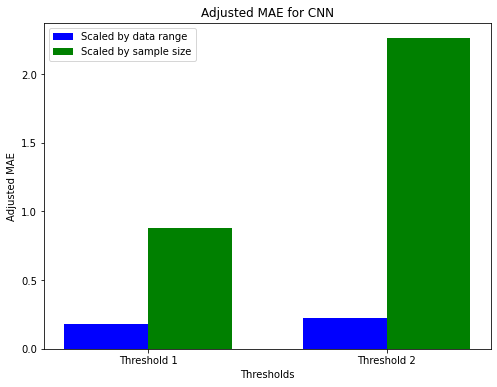

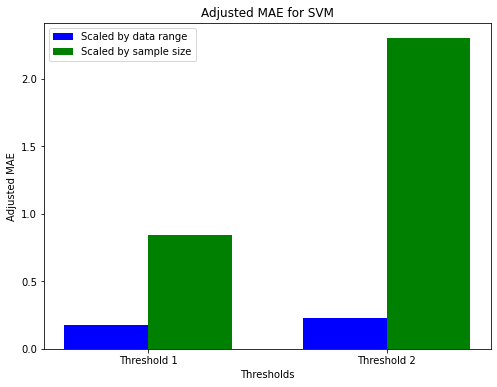

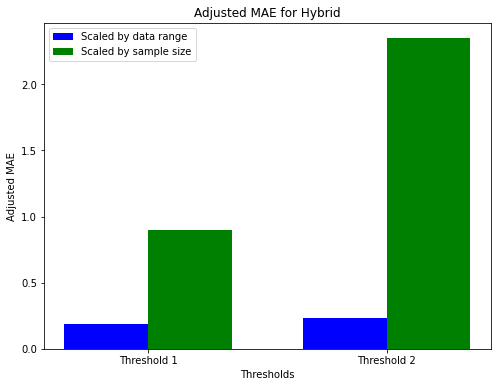

In [39]:
import matplotlib.pyplot as plt
import numpy as np

adjusted_mae_cnn_range = [adjusted_mae_cnn1_range, adjusted_mae_cnn2_range]
adjusted_mae_cnn_sample = [adjusted_mae_cnn1_sample_size, adjusted_mae_cnn2_sample_size]
adjusted_mae_svm_range = [adjusted_mae_svm1_range, adjusted_mae_svm2_range]
adjusted_mae_svm_sample = [adjusted_mae_svm1_sample_size, adjusted_mae_svm2_sample_size]
adjusted_mae_hybrid_range = [adjusted_mae_hybrid1_range, adjusted_mae_hybrid2_range]
adjusted_mae_hybrid_sample = [adjusted_mae_hybrid1_sample_size, adjusted_mae_hybrid2_sample_size]

thresholds = ['Threshold 1', 'Threshold 2']

def plot_adjusted_mae(model_name, adjusted_mae_range, adjusted_mae_sample):
    plt.figure(figsize=(8, 6))
    x = np.arange(len(thresholds))
    width = 0.35
    plt.bar(x - width / 2, adjusted_mae_range, width, label='Scaled by data range', color='b')
    plt.bar(x + width / 2, adjusted_mae_sample, width, label='Scaled by sample size', color='g')
    
    plt.title(f'Adjusted MAE for {model_name}')
    plt.xlabel('Thresholds')
    plt.ylabel('Adjusted MAE')
    plt.xticks(x, thresholds)
    plt.legend()
    plt.show()

# Plot adjusted MAE for each model
plot_adjusted_mae('CNN', adjusted_mae_cnn_range, adjusted_mae_cnn_sample)
plot_adjusted_mae('SVM', adjusted_mae_svm_range, adjusted_mae_svm_sample)
plot_adjusted_mae('Hybrid', adjusted_mae_hybrid_range, adjusted_mae_hybrid_sample)

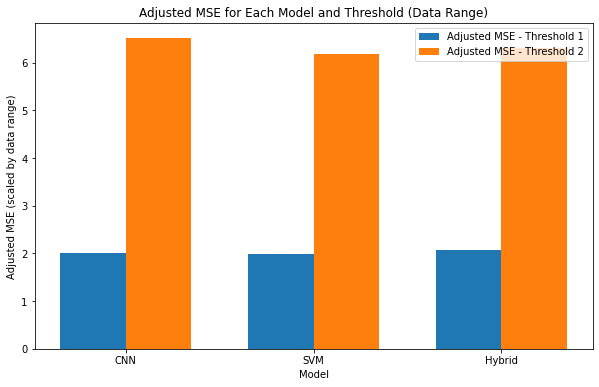

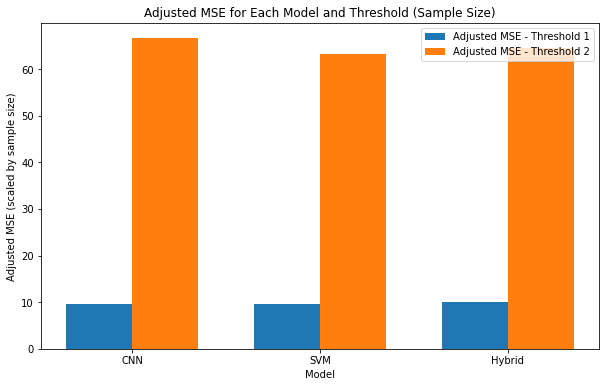

In [40]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = ['Threshold 1', 'Threshold 2']
models = ['CNN', 'SVM', 'Hybrid']

adjusted_mse_range_values = [
    [adjusted_mse_cnn1_range, adjusted_mse_cnn2_range],
    [adjusted_mse_svm1_range, adjusted_mse_svm2_range],
    [adjusted_mse_hybrid1_range, adjusted_mse_hybrid2_range]
]
adjusted_mse_sample_size_values = [
    [adjusted_mse_cnn1_sample_size, adjusted_mse_cnn2_sample_size],
    [adjusted_mse_svm1_sample_size, adjusted_mse_svm2_sample_size],
    [adjusted_mse_hybrid1_sample_size, adjusted_mse_hybrid2_sample_size]
]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

for i, threshold in enumerate(thresholds):
    ax.bar(x + i * width, [adjusted_mse_range_values[j][i] for j in range(len(models))],
           width, label=f'Adjusted MSE - {threshold}')

ax.set_xlabel('Model')
ax.set_ylabel('Adjusted MSE (scaled by data range)')
ax.set_title('Adjusted MSE for Each Model and Threshold (Data Range)')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

for i, threshold in enumerate(thresholds):
    ax.bar(x + i * width, [adjusted_mse_sample_size_values[j][i] for j in range(len(models))],
           width, label=f'Adjusted MSE - {threshold}')

ax.set_xlabel('Model')
ax.set_ylabel('Adjusted MSE (scaled by sample size)')
ax.set_title('Adjusted MSE for Each Model and Threshold (Sample Size)')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models)
ax.legend()
plt.show()


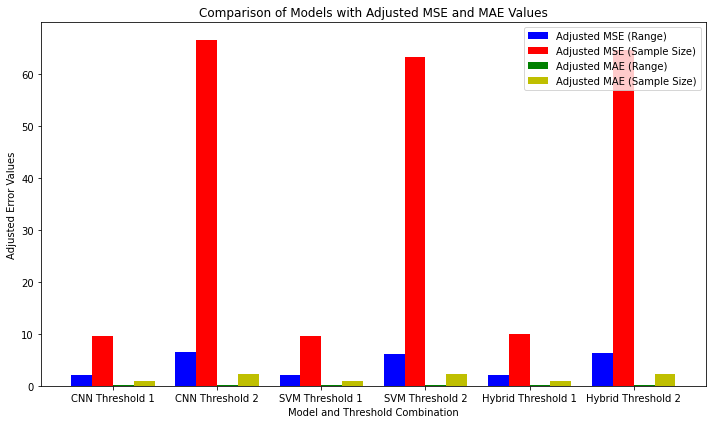

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(models, adjusted_mse_range, adjusted_mse_sample_size, adjusted_mae_range, adjusted_mae_sample_size):
    bar_width = 0.2
    index = np.arange(len(models))
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bar1 = ax.bar(index, adjusted_mse_range, width=bar_width, label='Adjusted MSE (Range)', color='b')
    bar2 = ax.bar(index + bar_width, adjusted_mse_sample_size, width=bar_width, label='Adjusted MSE (Sample Size)', color='r')
    bar3 = ax.bar(index + bar_width * 2, adjusted_mae_range, width=bar_width, label='Adjusted MAE (Range)', color='g')
    bar4 = ax.bar(index + bar_width * 3, adjusted_mae_sample_size, width=bar_width, label='Adjusted MAE (Sample Size)', color='y')
    
    ax.set_xticks(index + bar_width * 1.5)
    ax.set_xticklabels(models)

    ax.set_xlabel('Model and Threshold Combination')
    ax.set_ylabel('Adjusted Error Values')
    ax.set_title('Comparison of Models with Adjusted MSE and MAE Values')
    ax.legend()
    plt.tight_layout()
    plt.show()


models = ['CNN Threshold 1', 'CNN Threshold 2', 'SVM Threshold 1', 'SVM Threshold 2', 'Hybrid Threshold 1', 'Hybrid Threshold 2']


adjusted_mse_range = [adjusted_mse_cnn1_range, adjusted_mse_cnn2_range, adjusted_mse_svm1_range, adjusted_mse_svm2_range, adjusted_mse_hybrid1_range, adjusted_mse_hybrid2_range]
adjusted_mse_sample_size = [adjusted_mse_cnn1_sample_size, adjusted_mse_cnn2_sample_size, adjusted_mse_svm1_sample_size, adjusted_mse_svm2_sample_size, adjusted_mse_hybrid1_sample_size, adjusted_mse_hybrid2_sample_size]


adjusted_mae_range = [adjusted_mae_cnn1_range, adjusted_mae_cnn2_range, adjusted_mae_svm1_range, adjusted_mae_svm2_range, adjusted_mae_hybrid1_range, adjusted_mae_hybrid2_range]
adjusted_mae_sample_size = [adjusted_mae_cnn1_sample_size, adjusted_mae_cnn2_sample_size, adjusted_mae_svm1_sample_size, adjusted_mae_svm2_sample_size, adjusted_mae_hybrid1_sample_size, adjusted_mae_hybrid2_sample_size]

plot_comparison(models, adjusted_mse_range, adjusted_mse_sample_size, adjusted_mae_range, adjusted_mae_sample_size)
